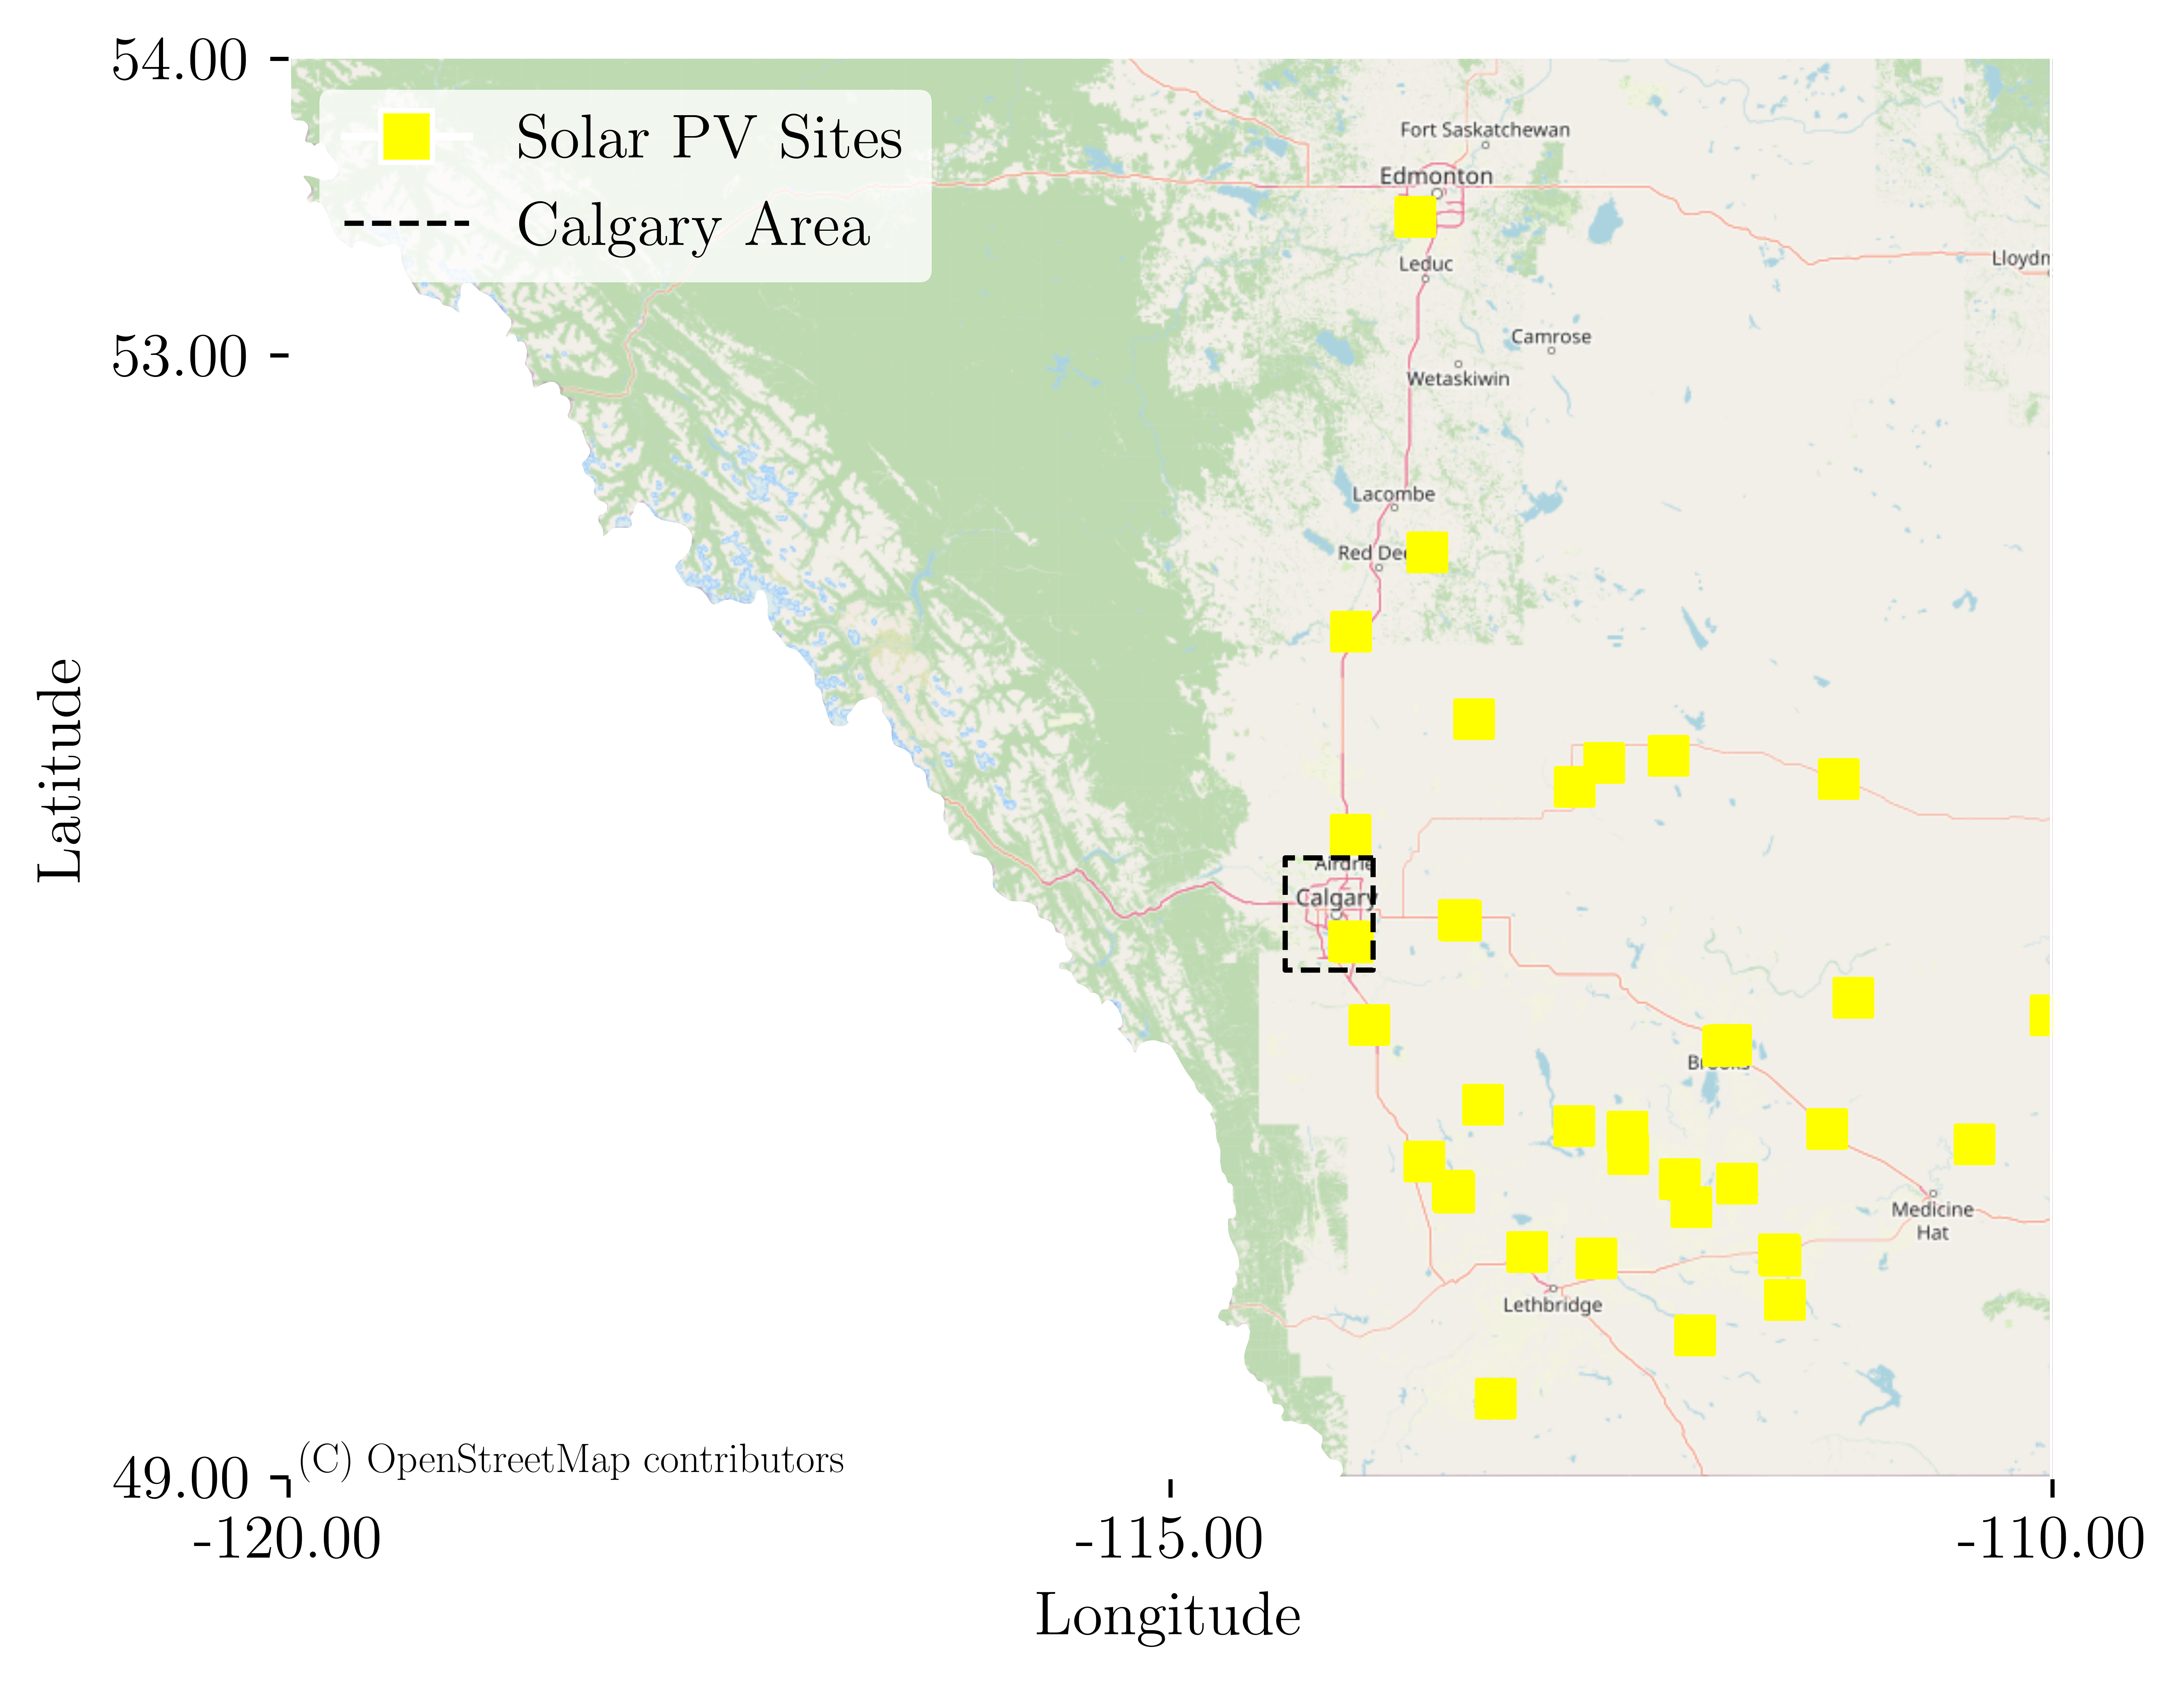

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point, Polygon, box
from matplotlib.lines import Line2D
from shapely.ops import unary_union
import pandas as pd

df_farms = pd.read_csv('alberta-solar-farms.csv')

initial_coordinates = []
for index, row in df_farms.iterrows():
    initial_coordinates.append((row['latitude'], row['longitude']))

# Bounding box of Calgary with padding
max_y_rounded_up = -113.9 + 0.05
min_y_rounded_down = -114.3 - 0.05
max_x_rounded_up = 51.2 + 0.05
min_x_rounded_down = 50.9 - 0.05

# Create a polygon that represents the bounding box
bbox_coords = [
    (max_y_rounded_up, max_x_rounded_up),
    (max_y_rounded_up, min_x_rounded_down),
    (min_y_rounded_down, min_x_rounded_down),
    (min_y_rounded_down, max_x_rounded_up),
    (max_y_rounded_up, max_x_rounded_up)  # Closing the polygon
]

# Enable LaTeX for text rendering with mathptmx
plt.rc('text', usetex=True)
plt.rc('font', family='serif')  # Use serif fonts
plt.rc('font', size=12)  # Change to desired font size

# Convert Solar PV Sites coordinates to GeoDataFrame
solar_pv_geometry = [Point(lon, lat) for lat, lon in initial_coordinates]
solar_pv_gdf = gpd.GeoDataFrame(geometry=solar_pv_geometry, crs="EPSG:4326")

# Convert bounding box to GeoDataFrame
bbox_polygon = Polygon(bbox_coords)
initial_gdf4 = gpd.GeoDataFrame(geometry=[bbox_polygon], crs="EPSG:4326")

# Load the Alberta boundary shapefile and filter for Alberta
alberta_boundary = gpd.read_file('ne_10m_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp')
alberta_boundary = alberta_boundary[alberta_boundary['name'] == 'Alberta']  # Filter for Alberta only

# Plot the map with the basemap
fig, ax = plt.subplots(figsize=(6, 7), dpi=1000)  # Adjusted figure size for Alberta
solar_pv_gdf = solar_pv_gdf.to_crs(epsg=3857)
initial_gdf4 = initial_gdf4.to_crs(epsg=3857)
alberta_boundary = alberta_boundary.to_crs(epsg=3857)

# Plot the Solar PV Sites
solar_pv_gdf.plot(ax=ax, color='yellow', marker='s', markersize=50, label='Solar PV Sites')

# Plot the bounding box with a dashed line
initial_gdf4.plot(ax=ax, color='none', edgecolor='black', linestyle='--', linewidth=1, label='Calgary Area')

# Plot the Alberta boundary
alberta_boundary.plot(ax=ax, color='none', edgecolor='white', linewidth=1, label='Alberta Boundary')

# Add the OpenStreetMap basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=7)

# Create a mask for the area outside Alberta
# Get the bounds of the entire map
minx, miny, maxx, maxy = alberta_boundary.total_bounds

# Create a polygon covering the entire map area with the new maxy
entire_map = box(minx, miny, maxx, maxy)

# Clip the Alberta boundary to the new maxy value (if necessary)
alberta_clipped = alberta_boundary[alberta_boundary.geometry.intersects(entire_map)]

# Create a mask polygon by subtracting the Alberta boundary from the entire map
mask_polygon = entire_map.difference(unary_union(alberta_clipped.geometry))

# Plot the mask polygon in white
mask_gdf = gpd.GeoDataFrame(geometry=[mask_polygon], crs="EPSG:3857")
mask_gdf.plot(ax=ax, color='white', edgecolor='white')

# Function to convert latitude/longitude (EPSG:4326) to Web Mercator (EPSG:3857)
def to_web_mercator(lon, lat):
    point = gpd.GeoSeries([Point(lon, lat)], crs="EPSG:4326")
    point = point.to_crs("EPSG:3857")
    return point.x[0], point.y[0]  # Return x, y in Web Mercator

# Set the extent to cover Alberta but stop at 56°N
_, max_y = to_web_mercator(0, 54.0)  # Convert 56°N to Web Mercator
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, max_y)  # This will stop the map at 56°N

# Set plot title and labels
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Define specific ticks in latitude/longitude (EPSG:4326)
xticks_4326 = [-120.00, -115.00, -110.00]  # Longitude values
yticks_4326 = [49.00, 53, 54.00]  # Latitude values

# Convert ticks to Web Mercator (EPSG:3857)
xticks_3857 = [to_web_mercator(lon, 0)[0] for lon in xticks_4326]  # Convert longitude
yticks_3857 = [to_web_mercator(0, lat)[1] for lat in yticks_4326]  # Convert latitude

# Set the ticks and tick labels
ax.set_xticks(xticks_3857)
ax.set_xticklabels([f"{lon:.2f}" for lon in xticks_4326])  # Use original longitude labels
ax.set_yticks(yticks_3857)
ax.set_yticklabels([f"{lat:.2f}" for lat in yticks_4326])  # Use original latitude labels

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# Create custom legend handles
solar_handle = Line2D([0], [0], marker='s', color='w', markerfacecolor='yellow', markersize=10, label='Solar PV Sites')
bbox_handle = Line2D([0], [0], color='black', linestyle='--', linewidth=1, label='Calgary Area')
alberta_handle = Line2D([0], [0], color='black', linewidth=1, label='Alberta Boundary')

# Add legend
legend = plt.legend(handles=[solar_handle, bbox_handle], loc='upper left')
frame = legend.get_frame()
frame.set_edgecolor('none')

# Save the figure to a PDF
plt.tight_layout()
plt.savefig("Alberta_Map_Solar.pdf", format="pdf", bbox_inches="tight", dpi=100)
plt.show()